# Description

In [1]:
# TODO(Dan): consider generalizing the notebook, i.e. move the code to a lib to compare OHLCV bars.

Compare historical data stored in Parquet with data from database.

# Imports

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import datetime
import logging

import pandas as pd

import core.config as cconfig
import core.plotting as coplotti
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import im_v2.ccxt.data.client as icdcl
import im_v2.common.universe as ivcu

/app/amp/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


In [4]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-a14f33a5-847a-454c-98e2-fa058e0b9c36.json'
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.10.0' != container_version='1.12.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CmTask6537_One_off_comparison_of_Parquet_and_DB_OHLCV_data'
  hash='51671aaca'
  # Last commits:
    *   51671aaca Dan      Merge branch 'master' into CmTask6537_One_off_comparison_of_Parquet_and_DB_OHLCV_data (   3 hours ago) Mon Jan 15 13:55:15 2024  (HEAD -> CmTask6537_One_off_comparison_of_Parquet_and_DB_OHLCV_data, origin/CmTask6537_One_off_comparison_of_Parquet_and_DB_OHLCV_data)
    |\  
    | * 408cff90d Danya Tikh

# Config

In [5]:
universe_version = "v7.4"
config_dict = {
    "universe_kwargs": {
        "vendor": "CCXT",
        "mode": "trade",
        "version": universe_version,
        "as_full_symbol": True,
    },
    "pq_client_config": {
        "data_version": "v3",
        "universe_version": universe_version,
        "dataset": "ohlcv",
        "contract_type": "futures",
        "data_snapshot": "",
    },
    "db_client_config": {
        "universe_version": "infer_from_data",
        "db_stage": "prod",
        "table_name": "ccxt_ohlcv_futures",
    },
    "read_data_kwargs": {
        "start_ts": pd.Timestamp(datetime.date(2023, 11, 1), tz="UTC"),
        "end_ts": pd.Timestamp(datetime.date(2023, 11, 30), tz="UTC"),
        "columns": None,
        "filter_data_mode": "assert",
    },
    "columns_to_compare": [
        "timestamp",
        "full_symbol",
        "open",
        "high",
        "low",
        "close",
        "volume",
    ],
}
config = cconfig.Config().from_dict(config_dict)
print(config)

universe_kwargs: 
  vendor: CCXT
  mode: trade
  version: v7.4
  as_full_symbol: True
pq_client_config: 
  data_version: v3
  universe_version: v7.4
  dataset: ohlcv
  contract_type: futures
  data_snapshot: 
db_client_config: 
  universe_version: infer_from_data
  db_stage: prod
  table_name: ccxt_ohlcv_futures
read_data_kwargs: 
  start_ts: 2023-11-01 00:00:00+00:00
  end_ts: 2023-11-30 00:00:00+00:00
  columns: None
  filter_data_mode: assert
columns_to_compare: ['timestamp', 'full_symbol', 'open', 'high', 'low', 'close', 'volume']


# Compare Parquet and DB data

## Load data

In [6]:
full_symbols = ivcu.get_vendor_universe(**config["universe_kwargs"])
full_symbols

['binance::APE_USDT',
 'binance::AVAX_USDT',
 'binance::AXS_USDT',
 'binance::BAKE_USDT',
 'binance::BNB_USDT',
 'binance::BTC_USDT',
 'binance::CTK_USDT',
 'binance::DOGE_USDT',
 'binance::DOT_USDT',
 'binance::DYDX_USDT',
 'binance::ETH_USDT',
 'binance::FTM_USDT',
 'binance::GMT_USDT',
 'binance::LINK_USDT',
 'binance::MATIC_USDT',
 'binance::NEAR_USDT',
 'binance::OGN_USDT',
 'binance::RUNE_USDT',
 'binance::SAND_USDT',
 'binance::SOL_USDT',
 'binance::STORJ_USDT',
 'binance::UNFI_USDT',
 'binance::WAVES_USDT',
 'binance::XRP_USDT']

In [7]:
pq_im_client = icdcl.get_CcxtHistoricalPqByTileClient_example1(
    **config["pq_client_config"]
)
pq_ohlcv_data = pq_im_client.read_data(
    full_symbols,
    **config["read_data_kwargs"],
)
pq_ohlcv_data = pq_ohlcv_data.reset_index()
pq_ohlcv_data = pq_ohlcv_data[config["columns_to_compare"]]
print(pq_ohlcv_data.shape)
pq_ohlcv_data.head()

(1002201, 7)


,timestamp,full_symbol,open,high,low,close,volume
0,2023-11-01 00:00:00+00:00,binance::APE_USDT,1.3270,1.3280,1.3260,1.3270,26722.00
1,2023-11-01 00:00:00+00:00,binance::AVAX_USDT,11.3340,11.3380,11.3280,11.3280,9802.00
2,2023-11-01 00:00:00+00:00,binance::AXS_USDT,5.4600,5.4600,5.4540,5.4540,10035.00
3,2023-11-01 00:00:00+00:00,binance::BAKE_USDT,0.1303,0.1304,0.1302,0.1303,47313.00
4,2023-11-01 00:00:00+00:00,binance::BNB_USDT,226.4500,226.4600,226.3400,226.3500,243.29


In [8]:
db_im_client = icdcl.get_CcxtSqlRealTimeImClient_example1(
    **config["db_client_config"]
)
db_ohlcv_data = db_im_client.read_data(
    full_symbols,
    **config["read_data_kwargs"],
)
#
db_ohlcv_data = db_ohlcv_data.reset_index()
db_ohlcv_data = db_ohlcv_data[config["columns_to_compare"]]
print(db_ohlcv_data.shape)
db_ohlcv_data.head()

INFO  Unable to fetch DB credentials from environment variables: 
	'POSTGRES_HOST'
	Attempting env file method.
INFO  Unable to fetch DB credentials from env file: 
	
################################################################################
* Failed assertion *
File '/app/amp/im_v2/devops/env/prod.im_db_config.env' doesn't exist
################################################################################

	Attempting AWS SecretsManager method.
INFO  Fetching secret: prod.im_data_db.read_only
INFO  Created prod DB connection: 
 None


/app/amp/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


(1002264, 7)


,timestamp,full_symbol,open,high,low,close,volume
0,2023-11-01 00:00:00+00:00,binance::APE_USDT,1.3270,1.3280,1.3260,1.3270,26722.00
1,2023-11-01 00:00:00+00:00,binance::AVAX_USDT,11.3340,11.3380,11.3280,11.3280,9802.00
2,2023-11-01 00:00:00+00:00,binance::AXS_USDT,5.4600,5.4600,5.4540,5.4540,10035.00
3,2023-11-01 00:00:00+00:00,binance::BAKE_USDT,0.1303,0.1304,0.1302,0.1303,47313.00
4,2023-11-01 00:00:00+00:00,binance::BNB_USDT,226.4500,226.4600,226.3400,226.3500,243.29


## Total

In [9]:
# Check that data does not contain duplicates.
hdbg.dassert_eq(0, pq_ohlcv_data.duplicated().sum())
hdbg.dassert_eq(0, db_ohlcv_data.duplicated().sum())

In [10]:
# Difference in data length.
len_diff = len(pq_ohlcv_data) - len(db_ohlcv_data)
_LOG.info("Length PQ data=%s", len(pq_ohlcv_data))
_LOG.info("Length DB data=%s", len(db_ohlcv_data))
_LOG.info(
    "Percentage of rows that are not intersecting=%s",
    len_diff / max(len(pq_ohlcv_data), len(db_ohlcv_data)) * 100,
)

INFO  Length PQ data=1002201
INFO  Length DB data=1002264
INFO  Percentage of rows that are not intersecting=-0.006285769018941117


In [11]:
# Merge dataframes in order to align data on timestamp and full symbol.
merged_df = pd.merge(
    pq_ohlcv_data,
    db_ohlcv_data,
    on=["timestamp", "full_symbol"],
    suffixes=("_pq", "_db"),
    how="inner",
)
merged_df = merged_df.set_index(["timestamp", "full_symbol"])
#
_LOG.info("Merged data shape=%s", merged_df.shape)
merged_df.head()

INFO  Merged data shape=(1002201, 10)


open_pq   high_pq    low_pq  close_pq  volume_pq   open_db   high_db    low_db  close_db  volume_db
timestamp                 full_symbol                                                                                                             
2023-11-01 00:00:00+00:00 binance::APE_USDT     1.3270    1.3280    1.3260    1.3270   26722.00    1.3270    1.3280    1.3260    1.3270   26722.00
                          binance::AVAX_USDT   11.3340   11.3380   11.3280   11.3280    9802.00   11.3340   11.3380   11.3280   11.3280    9802.00
                          binance::AXS_USDT     5.4600    5.4600    5.4540    5.4540   10035.00    5.4600    5.4600    5.4540    5.4540   10035.00
                          binance::BAKE_USDT    0.1303    0.1304    0.1302    0.1303   47313.00    0.1303    0.1304    0.1302    0.1303   47313.00
                          binance::BNB_USDT   226.4500  226.4600  226.3400  226.3500     243.29  226.4500  226.4600  226.3400  226.3500     243.29

In [12]:
# Get number of minutes in the data time interval.
n_minutes = len(merged_df.unstack())
_LOG.info("N minutes=%s", n_minutes)

INFO  N minutes=41761


In [13]:
# Get number of days the observations are loaded for.
unique_days = set(merged_df.unstack().index.date)
_LOG.info("N unique days=%s", len(unique_days))

INFO  N unique days=30


In [14]:
# Split merged data on aligned Parquet and DB data.
pq_data = merged_df[
    ["open_pq", "high_pq", "low_pq", "close_pq", "volume_pq"]
].copy()
pq_data.columns = ["open", "high", "low", "close", "volume"]
#
db_data = merged_df[
    ["open_db", "high_db", "low_db", "close_db", "volume_db"]
].copy()
db_data.columns = ["open", "high", "low", "close", "volume"]

In [15]:
df_diff = hpandas.compare_dfs(
    pq_data,
    db_data,
    compare_nans=True,
).abs()
df_diff.max().max()

6343658.0

In [16]:
df_is_diff = (df_diff > 0.001).sum(axis=1)
total_diff_rows = df_is_diff[df_is_diff > 0]
diff_rows_perc = (len(total_diff_rows) / len(df_is_diff)) * 100
_LOG.info(
    "Percentage of rows at intersecting time interval with abs diff > 0.001=%s",
    round(diff_rows_perc, 2),
)

INFO  Percentage of rows at intersecting time interval with abs diff > 0.001=0.19


## NaNs

In [17]:
# Get observations for which there is data in 1 df and no data in another.
nan_diff_df = hpandas.compare_nans_in_dataframes(pq_data, db_data)
print(len(nan_diff_df))
nan_diff_df.head()

0


timestamp,full_symbol


In [18]:
# Get all the timestamps for which there is a difference with NaN.
nan_diff_timestamps = nan_diff_df.unstack().index
_LOG.info("N minutes with NaN diff=%s", len(nan_diff_timestamps))
_LOG.info(
    "Percentage of minutes with NaN diff=%s",
    len(nan_diff_timestamps) / n_minutes * 100,
)
nan_diff_timestamps

INFO  N minutes with NaN diff=0
INFO  Percentage of minutes with NaN diff=0.0


DatetimeIndex([], dtype='datetime64[ns, UTC]', name='timestamp', freq=None)

## Per bar timestamp

In [19]:
# Get a bool series representing if a row has any differing values.
ts_diff_rows = (df_diff > 0.001).any(axis=1)
ts_diff_rows

timestamp                  full_symbol        
2023-11-01 00:00:00+00:00  binance::APE_USDT      False
                           binance::AVAX_USDT     False
                           binance::AXS_USDT      False
                           binance::BAKE_USDT     False
                           binance::BNB_USDT      False
                                                  ...  
2023-11-30 00:00:00+00:00  binance::SOL_USDT      False
                           binance::STORJ_USDT    False
                           binance::UNFI_USDT     False
                           binance::WAVES_USDT    False
                           binance::XRP_USDT      False
Length: 1002201, dtype: bool

<Axes: xlabel='date'>

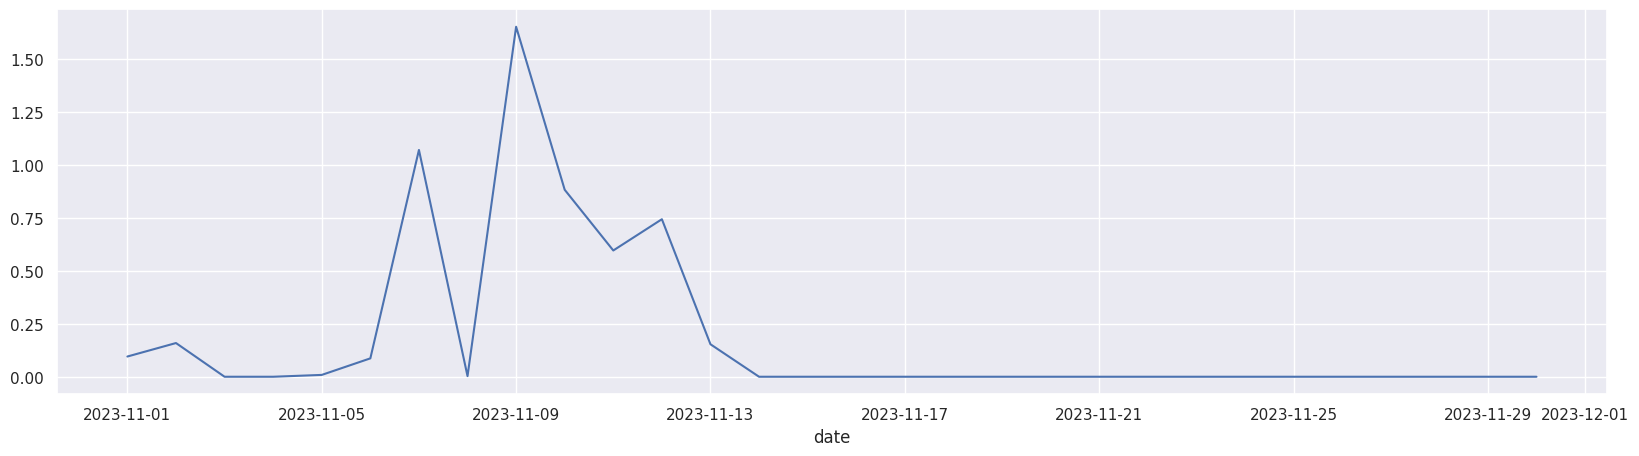

In [20]:
# Get number of rows per date.
df_ts_diff_rows = ts_diff_rows.reset_index()
df_ts_diff_rows["date"] = df_ts_diff_rows["timestamp"].dt.date
n_rows_per_date = df_ts_diff_rows["date"].value_counts()
# Get differing rows for all the unique dates.
n_diff_rows_per_date = df_ts_diff_rows.groupby("date")[0].sum()
# Get percentage of missing rows per date.
perc_diff_rows_per_date = (n_diff_rows_per_date / n_rows_per_date).dropna() * 100
#
perc_diff_rows_per_date.plot()

INFO  Percentage of days with value differences=36.666666666666664


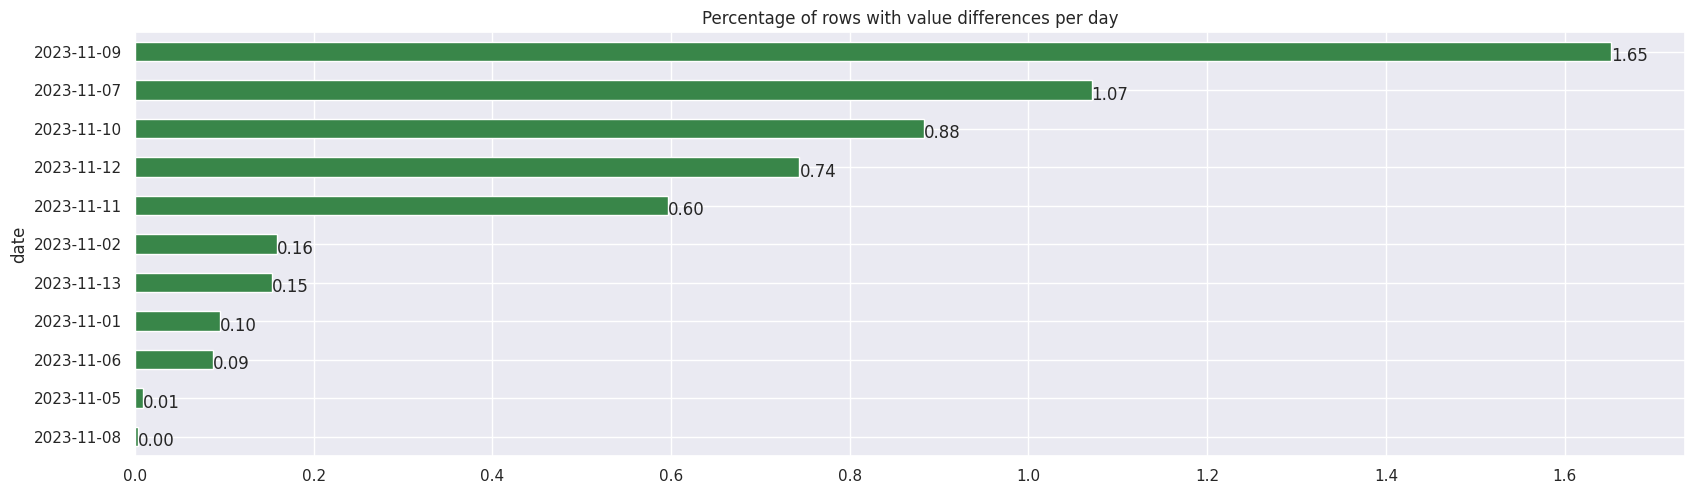

In [21]:
rows_to_plot = perc_diff_rows_per_date[perc_diff_rows_per_date > 0].sort_values()
# Stats are displayed only for days with differing rows.
coplotti.plot_barplot(
    rows_to_plot,
    orientation="horizontal",
    annotation_mode="value",
    title="Percentage of rows with value differences per day",
    figsize=(20, len(rows_to_plot) / 2),
)
_LOG.info(
    "Percentage of days with value differences=%s",
    len(rows_to_plot) / len(unique_days) * 100,
)

## Per asset

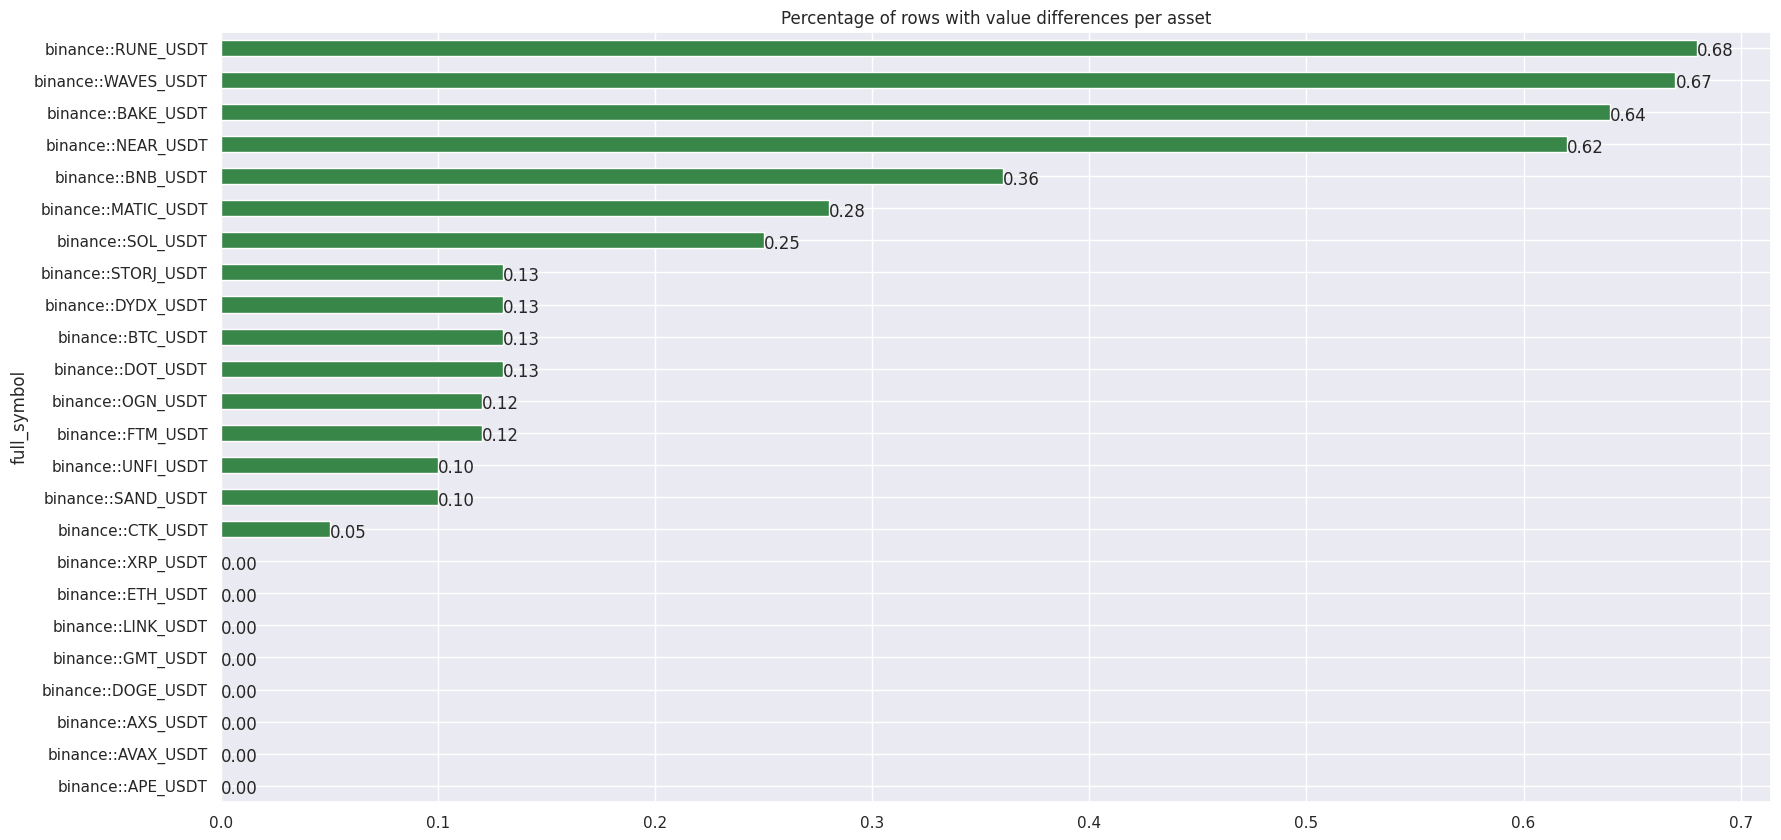

In [22]:
# Percentage of rows with value differences per asset.
asset_diff_row_count = (
    (df_diff > 0.001)
    .any(axis=1)
    .reset_index("full_symbol")
    .groupby("full_symbol")
    .sum()[0]
)
# Get number of rows per asset.
asset_n_rows = (
    df_diff.sum(axis=1)
    .reset_index("full_symbol")
    .groupby("full_symbol")
    .count()[0]
)
# Get percentage of missing rows per date.
perc_asset_diff_row_count = (asset_diff_row_count / asset_n_rows * 100).round(2)
#
coplotti.plot_barplot(
    perc_asset_diff_row_count.sort_values(),
    orientation="horizontal",
    annotation_mode="value",
    title="Percentage of rows with value differences per asset",
    figsize=(20, 10),
)

## Per column

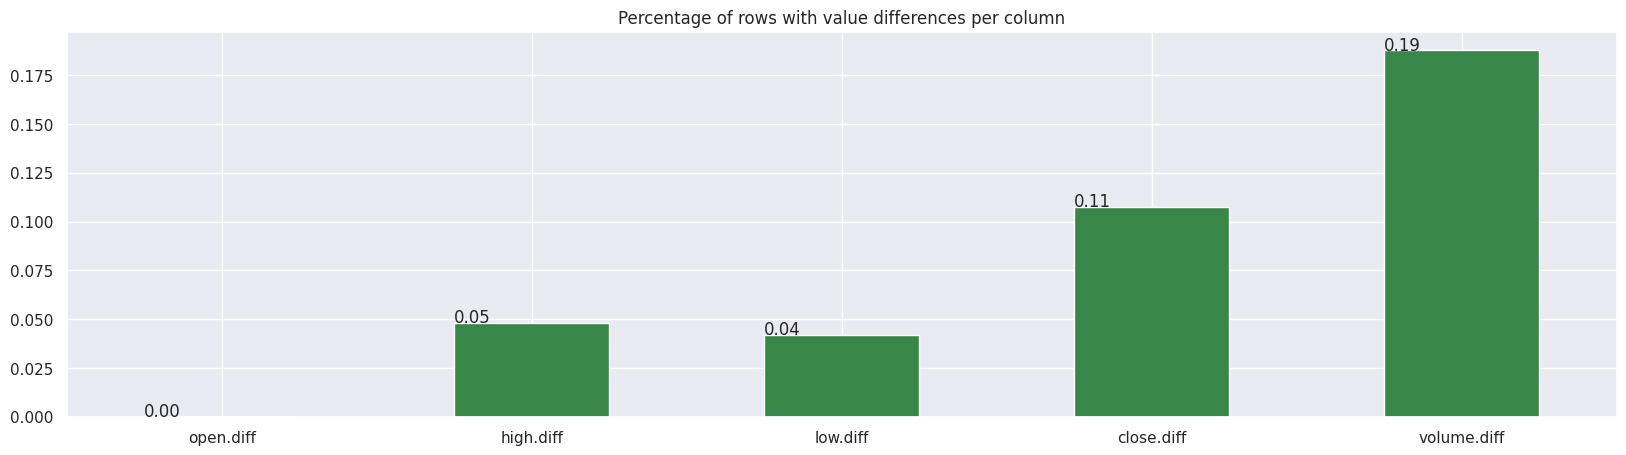

In [23]:
diff_row_count = (df_diff > 0.001).sum()
perc_diff_row_count = diff_row_count / len(df_diff) * 100
#
coplotti.plot_barplot(
    perc_diff_row_count,
    annotation_mode="value",
    title="Percentage of rows with value differences per column",
)